In [0]:
pip install quandl

In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(123)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
'''

quandl.ApiConfig.api_key = 'your_api_key_here'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

''' 

# Google drive access to dataset
from google.colab import drive
# Load the Drive helper and mount
drive.mount('/content/drive')

data_loc = "/content/drive/Shared drives/STAT40920_project/data/raw/QC_all_ind.csv"

import csv
headers_loc = "/content/drive/Shared drives/STAT40920_project/data/raw/industry_headers.csv"

headers = []

with open(headers_loc) as header_file:
  for row in csv.reader(header_file):
    headers.append(row)
headers = headers[0]

cum_ret = pd.read_csv(data_loc, names = headers)
cum_ret.head()
# note that we have applied the regex already

prices =cum_ret.loc[:,["Other","Agric","Hlth","Boxes","Paper","MedEq","Food","Fin","Clths","Trans"]]
prices.index = list(cum_ret.loc[:,"Date"])
prices

#Use our prices data here instead

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Other          Agric  ...          Clths          Trans
1969-07-01   4325.306930    1875.247152  ...    2749.391995    1721.684021
1969-07-02   4323.576807    1891.936851  ...    2762.589076    1734.768820
1969-07-03   4435.125089    1888.720559  ...    2780.545905    1746.565248
1969-07-07   4334.891262    1912.707310  ...    2768.311503    1725.431808
1969-07-08   4258.163687    1899.127088  ...    2719.312390    1702.138479
...                  ...            ...  ...            ...            ...
2019-09-24  16163.075790  190912.610800  ...  369351.588600  190454.406400
2019-09-25  16247.123780  190874.428300  ...  379434.887000  191749.496400
2019-09-26  16178.885860  187324.163900  ...  383001.574900  191461.872100
2019-09-27  16193.446860  187942.333700  ...  383193.075700  189891.884800
2019-09-30  16254.981960  187265.741300  ...  388136.266400  190081.776600

[12676 rows x 10 columns]

In [0]:
table = prices.tail(252)
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
#table.columns = [col[1] for col in table.columns]
#table.head()
table

Other        Agric  ...        Clths        Trans
2018-09-28  16375.80562  207297.4875  ...  372288.2245  212696.5579
2018-10-01  16562.48980  197637.4246  ...  370389.5546  212973.0635
2018-10-02  16615.48977  192933.6539  ...  363092.8804  210438.6840
2018-10-03  16671.98243  196329.2862  ...  364508.9426  211554.0090
2018-10-04  16787.01911  194719.3861  ...  354922.3574  210750.1038
...                 ...          ...  ...          ...          ...
2019-09-24  16163.07579  190912.6108  ...  369351.5886  190454.4064
2019-09-25  16247.12378  190874.4283  ...  379434.8870  191749.4964
2019-09-26  16178.88586  187324.1639  ...  383001.5749  191461.8721
2019-09-27  16193.44686  187942.3337  ...  383193.0757  189891.8848
2019-09-30  16254.98196  187265.7413  ...  388136.2664  190081.7766

[252 rows x 10 columns]

ValueError: ignored

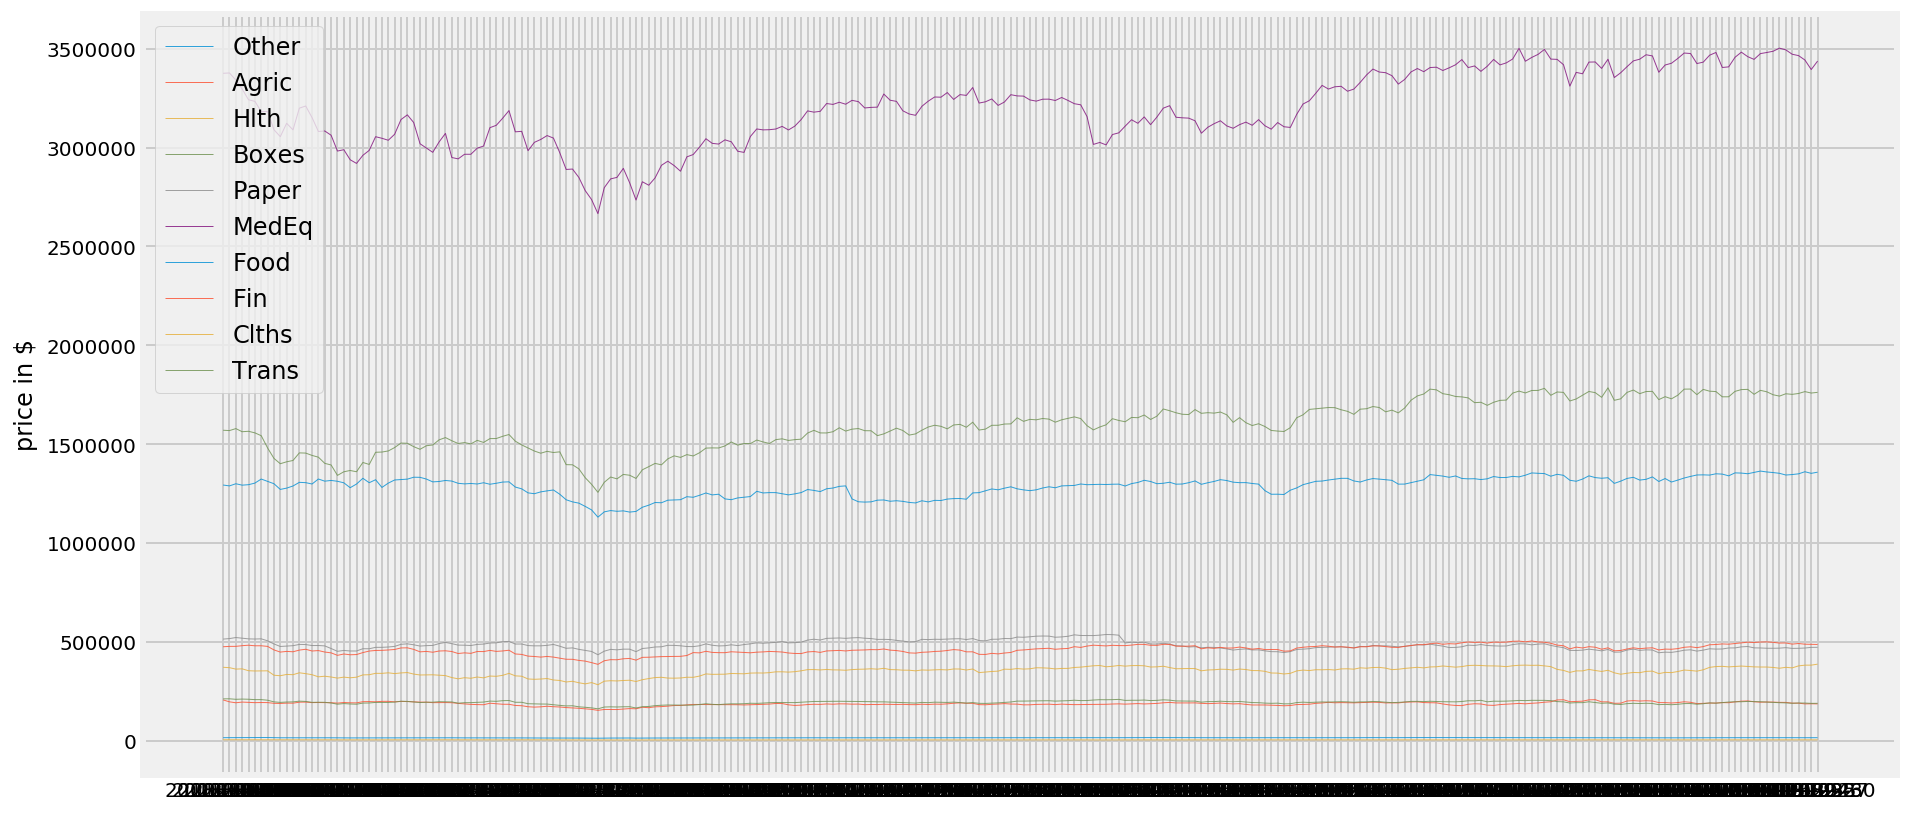

In [0]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=0.5, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.xlabel(table.index)
plt.savefig('prices')

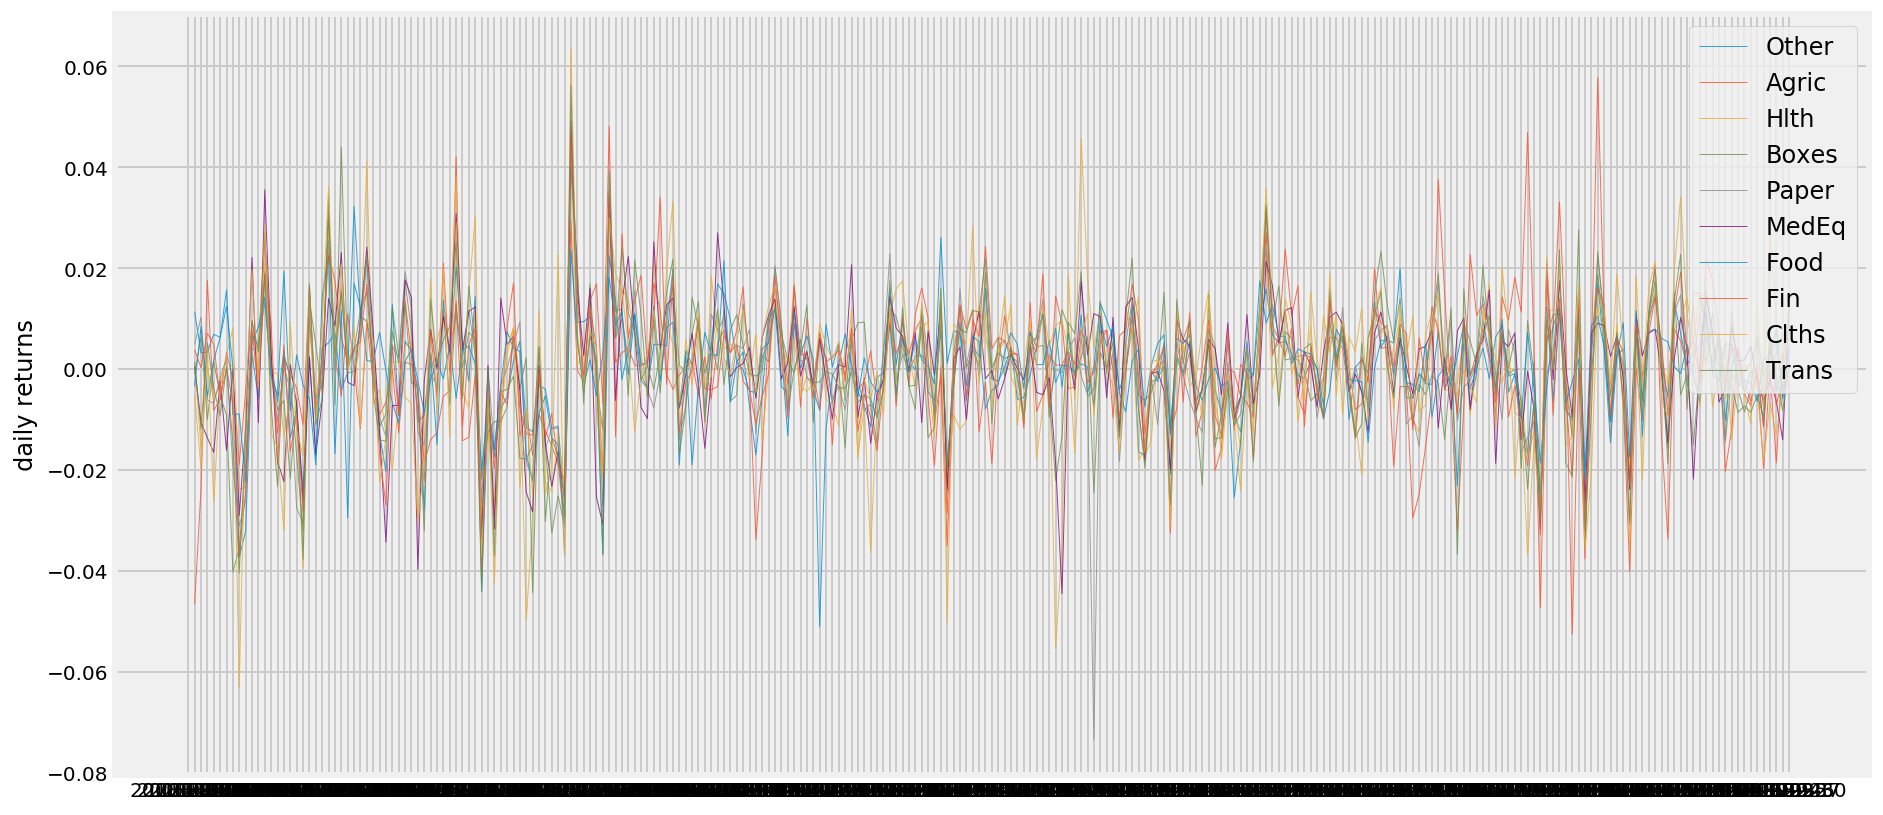

In [0]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=0.5, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [0]:
returns = table.pct_change()
returns.mean()

Other    0.000031
Agric   -0.000290
Hlth    -0.000212
Boxes    0.000543
Paper   -0.000261
MedEq    0.000159
Food     0.000239
Fin      0.000166
Clths    0.000284
Trans   -0.000357
dtype: float64

In [0]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [0]:
#Josh : Original Random Generator using uniform

def original_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    weights_record = []
    results = np.zeros((3,num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.uniform(-1,1,10)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [0]:
#Josh: new random with the grid, just the random though not the optimal

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    weights_record = portfolio_grid(10, n=3, upper = 0.25, lower = -0.25)
    #b1 = np.array([0.25,0.06872696,0.00921347,0.1706885,0.11489527,0.14019776,0.25,0.25,-0.00372195,-0.25])
    #b2 = np.array([0.25,0.03663639,-0.05120598,0.25,0.00860183,0.19224025,0.25,0.25,0.06372751,-0.25])
    #b3 = np.array([0.25,-0.03322313,-0.08584933,0.25,-0.13092754,0.25,0.25,0.25,0.25,-0.25])
    results = np.zeros((3,len(weights_record)))
    
    for i in range(len(weights_record)):
        #weights = np.random.uniform(-1,1,10)
        #weights /= np.sum(weights)
        #weights_record.append(weights)
        weights = weights_record[i,:]
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [0]:
#Josh : I've made this for plotting the optimal portfolios
#Josh : This is what you finished off with last night where it just plots the three portfolios

def optimal_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    weights_record = portfolio_grid(10, n=3, upper = 0.25, lower = -0.25)
    b1 = np.array([0.25,0.06872696,0.00921347,0.1706885,0.11489527,0.14019776,0.25,0.25,-0.00372195,-0.25])
    b2 = np.array([0.25,0.03663639,-0.05120598,0.25,0.00860183,0.19224025,0.25,0.25,0.06372751,-0.25])
    b3 = np.array([0.25,-0.03322313,-0.08584933,0.25,-0.13092754,0.25,0.25,0.25,0.25,-0.25])
    weights_record = np.vstack([b1, b2, b3])
    results = np.zeros((3,len(weights_record)))
    
    for i in range(len(weights_record)):
        #weights = np.random.uniform(-1,1,10)
        #weights /= np.sum(weights)
        #weights_record.append(weights)
        weights = weights_record[i,:]
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [0]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 700000
risk_free_rate = 0.0178

In [0]:
#corr = prices.corr()
corr = table.pct_change().corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)
#plt.savefig("correlation_matrix.png")

In [0]:

def is_efficient(results, n_bins):
    '''
    Made by Dunlop
    INPUTS:
    results : DataFrame (3,n) shape
              - 0: portfolio_std_dev
              - 1: portfolio_return
              - 2: sharpe
    n_bins : Float. Number of bins we divide the standard deviation axis into
    want to check each portfolio is efficient

    OUTPUT:
    efficient_frontier : Numpy Array
                          - Index of results corresponding to efficient portfolios

    How:
    1. Split portfolios into bins, use pandas qcut to give each portfolio a segment label
    2. Aggregate on the bin label, using max
    3. return the indexes for  
    '''
    results_t = pd.DataFrame(results.T, columns = ["portfolio_std_dev", "portfolio_return", "sharpe_ratio"])
    results_t = results_t[results_t["portfolio_std_dev"] < 1]
    results_t = results_t[results_t["portfolio_return"] > 0].sort_values("portfolio_return")
    # results_t["bin_label"] = pd.qcut(results_t["portfolio_return"], q = n_bins)
    results_t["bin_label"] = pd.cut(results_t["portfolio_return"], bins = n_bins)
    results_agg = results_t.groupby("bin_label").agg({"portfolio_std_dev" : ["idxmin"]}).reset_index()
    print(results_agg.head())
    return np.array(results_agg.iloc[:,1])

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    '''
    Results:
    results[0,] : portfolio_std_dev
    results[1,] : portfolio_return
    results[2,] : sharpe
    '''
    results, weights = original_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    ef_ret = results[1,is_efficient(results, nbins)]#
    ef_std = results[0,is_efficient(results, nbins)]#
    max_sharpe_idx = np.argmax(results[2])
    sdp = results[0,max_sharpe_idx], 
    rp = results[1,max_sharpe_idx]
    '''
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    '''
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    '''
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx,:],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    '''
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.axis([0, 0.6, -1, 1])
    plt.plot(ef_std, ef_ret,linestyle='-.', color='red', linewidth=2,label='efficient frontier')#
    plt.legend(labelspacing=0.8)
    plt.show()

            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00162, 0.0811]            661626
1     (0.0811, 0.162]            429980
2      (0.162, 0.243]            501521
3      (0.243, 0.324]            342591
4      (0.324, 0.405]            612823
            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00162, 0.0811]            661626
1     (0.0811, 0.162]            429980
2      (0.162, 0.243]            501521
3      (0.243, 0.324]            342591
4      (0.324, 0.405]            612823


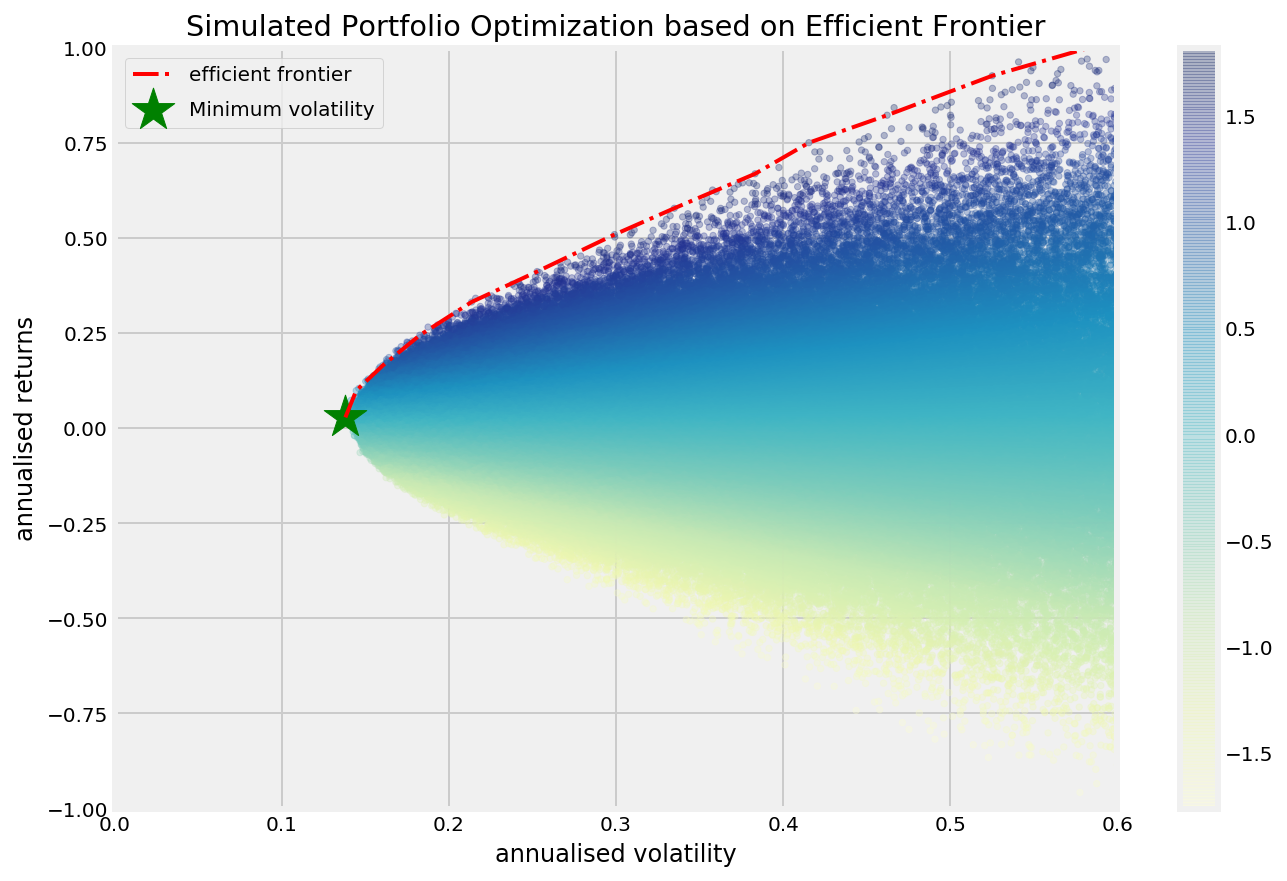

In [0]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [0]:
nbins = 20

display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00157, 0.0786]            118566
1     (0.0786, 0.157]            113737
2      (0.157, 0.236]            173834
3      (0.236, 0.314]             25521
4      (0.314, 0.393]            191030
            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00157, 0.0786]            118566
1     (0.0786, 0.157]            113737
2      (0.157, 0.236]            173834
3      (0.236, 0.314]             25521
4      (0.314, 0.393]            191030


TypeError: ignored

In [0]:
np.sqrt(0.01239942)

0.1113526829492671

In [0]:
def portfolio_grid(d, n=100, upper = 0.25, lower = -0.25):
  '''
  To generate weights efficiently for portfolios
  INPUTS
  d = number of dimensions to simulate
  n = number of steps to take between upper and lower
  upper = maximum allocation on one asset
  lower = maximum short posisiton allowed on one asset
  
  OUTPUTS:
  grid
  '''
  weight_vals = np.linspace(start = lower, stop = upper, endpoint=True, num=n)
  # weight_mat = np.tile(weight_vals, d)
  # print(weight_mat.shape)
  grid = np.array(np.meshgrid(*[weight_vals for i in range(d)])).T.reshape(-1,d)
  grid = grid[np.sum(grid, axis=1) == 1, :]
  return grid

#portfolio_grid(10, n=2, upper = 0.25, lower = -0.25)

In [0]:
np.linspace(start =-0.25, stop = 0.25, endpoint=True, num=6)

array([-0.25, -0.15, -0.05,  0.05,  0.15,  0.25])

In [0]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [0]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [0]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [0]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    #note how im using original portfolio uniform
    results, weights = original_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)#
    ef_ret = results[1,is_efficient(results, nbins)]#
    ef_std = results[0,is_efficient(results, nbins)]#

    #Optimal Only
    results_opt, weights_opt = optimal_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    #for i, txt in enumerate(table.columns):
    #    ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    
    #This line returns the correct loctions
    #ax.scatter(results_opt[0,:],results_opt[1,:],c=results_opt[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)

    '''
    vol = [results_opt[0,0],results_opt[0,1],results_opt[0,2]]
    ret = [results_opt[1,0],results_opt[1,1],results_opt[1,2]]
    n = ['b = 64.690271', 'b = 30.139119','b = 6.3065062']
    
    ax.scatter(vol, ret,marker='o',s=200,color='g')
    for i, txt in enumerate(n):
        ax.annotate(txt, (vol[i], ret[i]),xytext=(10,0), textcoords='offset points')
    '''
    ax.set_title('Portfolio Optimization with Individual Stocks')

    ax.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    #fig.colorbar()

    #maybe move back to after first scatter
    for i, txt in enumerate(table.columns):
      ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points',arrowprops=dict(facecolor='tab:orange'))

    ax.plot(ef_std, ef_ret, linestyle='-.', color='red', linewidth=3,label='efficient frontier')#
    '''
    ax.scatter(results_opt[0,0],results_opt[1,0],marker='v',color='b', s=300, label='b = 64.690271')
    ax.scatter(results_opt[0,1],results_opt[1,1],marker='v',color='y', s=300, label='b = 30.139119')
    ax.scatter(results_opt[0,2],results_opt[1,2],marker='v',color='m', s=300, label='b = 6.3065062')
    '''
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    plt.axis([0.1, 0.3, -0.25, 0.6])
    ax.legend(labelspacing=0.8)

            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00166, 0.0833]            508288
1     (0.0833, 0.167]            665992
2       (0.167, 0.25]             10396
3       (0.25, 0.333]             40663
4      (0.333, 0.416]            520894
            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00166, 0.0833]            508288
1     (0.0833, 0.167]            665992
2       (0.167, 0.25]             10396
3       (0.25, 0.333]             40663
4      (0.333, 0.416]            520894


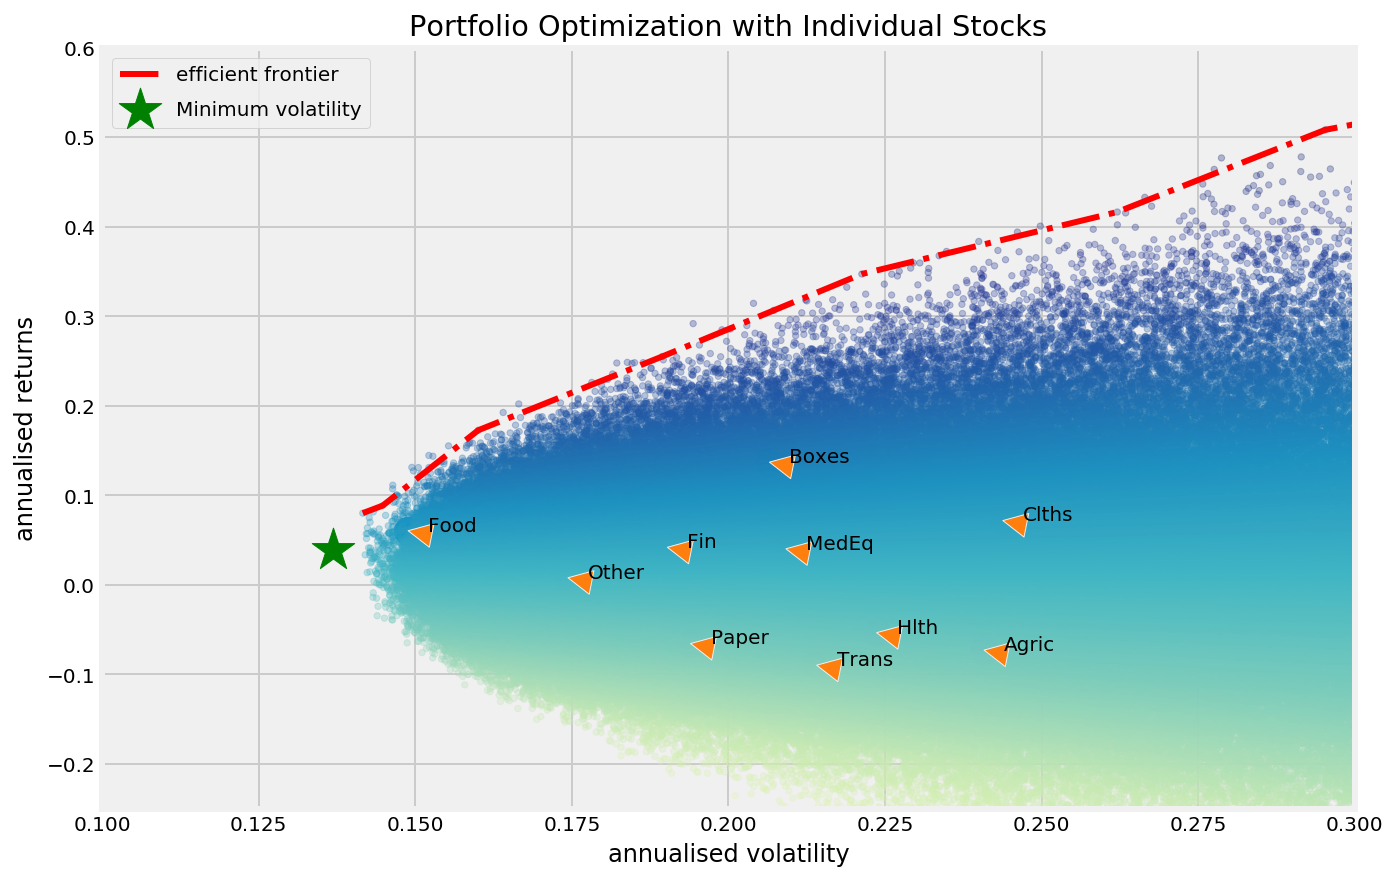

In [0]:
nbins = 20
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

           bin_label portfolio_std_dev
                                idxmin
0  (-0.00164, 0.082]             62904
1     (0.082, 0.164]             37171
2     (0.164, 0.246]            137023
3     (0.246, 0.328]            150987
4      (0.328, 0.41]            196806
           bin_label portfolio_std_dev
                                idxmin
0  (-0.00164, 0.082]             62904
1     (0.082, 0.164]             37171
2     (0.164, 0.246]            137023
3     (0.246, 0.328]            150987
4      (0.328, 0.41]            196806


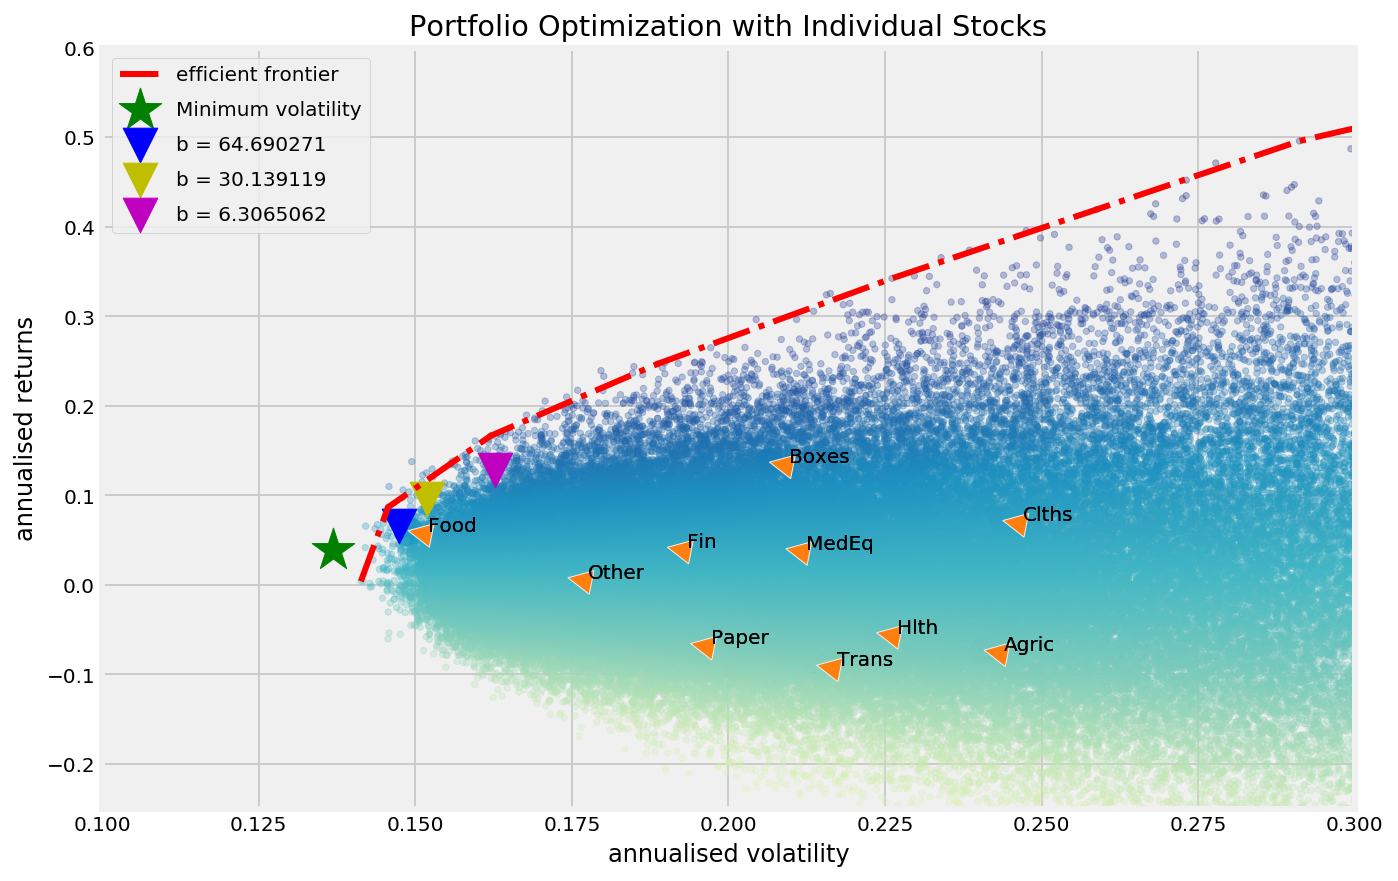

In [0]:
nbins = 20
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00157, 0.0784]            180740
1     (0.0784, 0.157]            119781
2      (0.157, 0.235]             53865
3      (0.235, 0.314]             88963
4      (0.314, 0.392]             21359
            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00157, 0.0784]            180740
1     (0.0784, 0.157]            119781
2      (0.157, 0.235]             53865
3      (0.235, 0.314]             88963
4      (0.314, 0.392]             21359


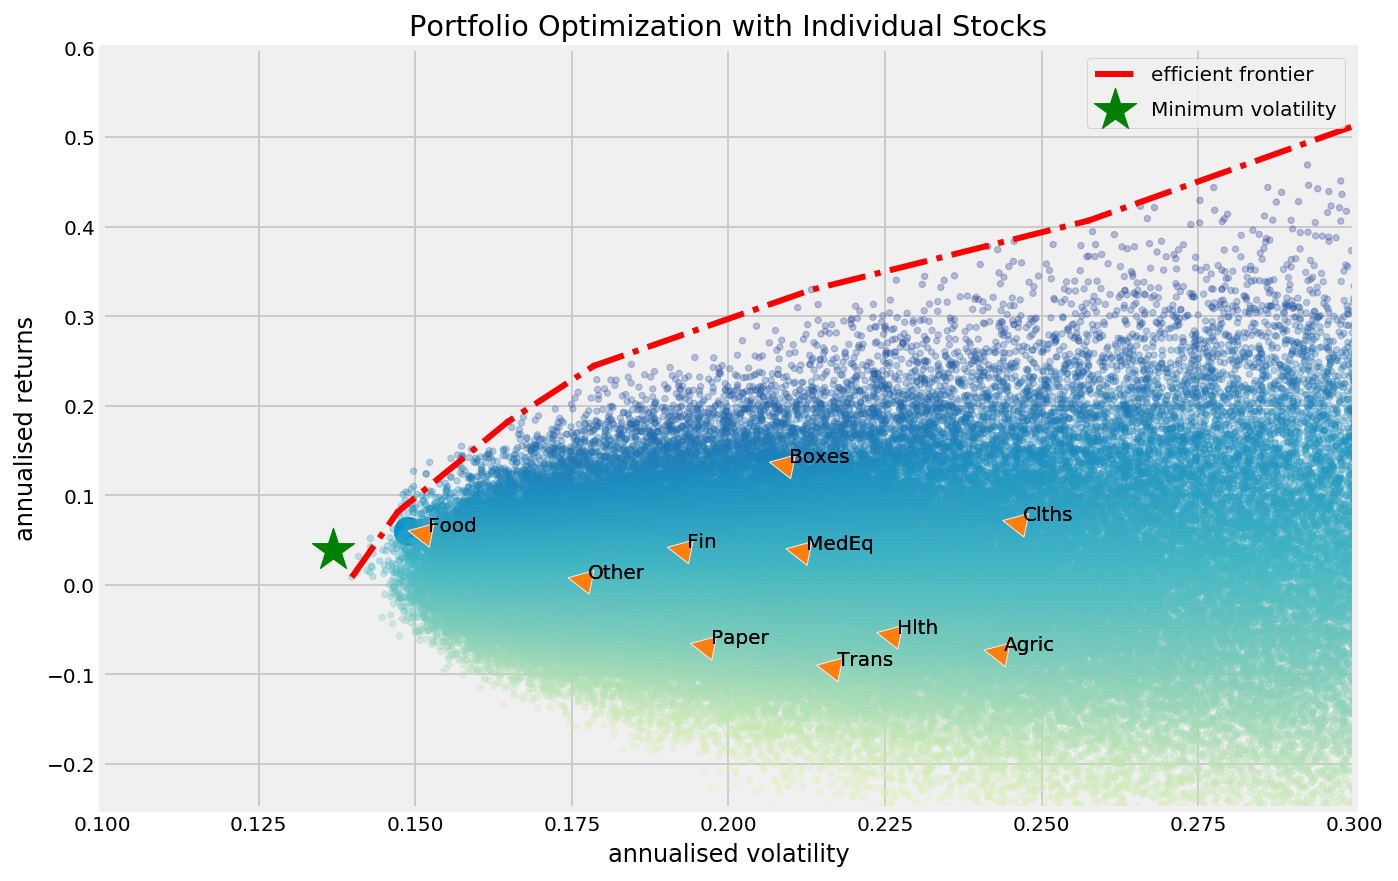

In [0]:
nbins = 20
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [0]:
nbins = 20
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

NameError: ignored

In [0]:
'''
b = 64.690271 
weights = pd.DataFrame([0.25,0.06872696,0.00921347,0.1706885,0.11489527,0.14019776,0.25,0.25,-0.00372195,-0.25])
port var = [0.01239942]
port_return = [0.12774231]

0.01239942,0.12774231


b = 30.139119
weights = pd.DataFrame([0.25,0.03663639,-0.05120598,0.25,0.00860183,0.19224025,0.25,0.25,0.06372751,-0.25])
port var = [[0.0129793]]
port_return = [0.11489227]

0.0129793,0.11489227

b = 6.3065062
weights = pd.DataFrame([0.25,-0.03322313,-0.08584933,0.25,-0.13092754,0.25,0.25,0.25,0.25,-0.25])
port var  = [[0.01443451]]
port_return = [0.10807708]

0.01443451,0.10807708
'''

vol = [0.01239942,0.0129793,0.01443451]
ret = [0.12774231, 0.11489227,0.10807708]
n = ['b = 64.690271', 'b = 30.139119','b = 6.3065062']

ax.scatter(vol, ret)

for i, txt in enumerate(n):
    ax.annotate(txt, (vol[i], ret[i]))


print(np.sqrt(0.01239942))#np.sqrt(252))
print(0.12774231)

0.1113526829492671
0.12774231


            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00164, 0.0819]            127208
1     (0.0819, 0.164]            105525
2      (0.164, 0.246]            161937
3      (0.246, 0.327]             61183
4      (0.327, 0.409]             19162
            bin_label portfolio_std_dev
                                 idxmin
0  (-0.00164, 0.0819]            127208
1     (0.0819, 0.164]            105525
2      (0.164, 0.246]            161937
3      (0.246, 0.327]             61183
4      (0.327, 0.409]             19162


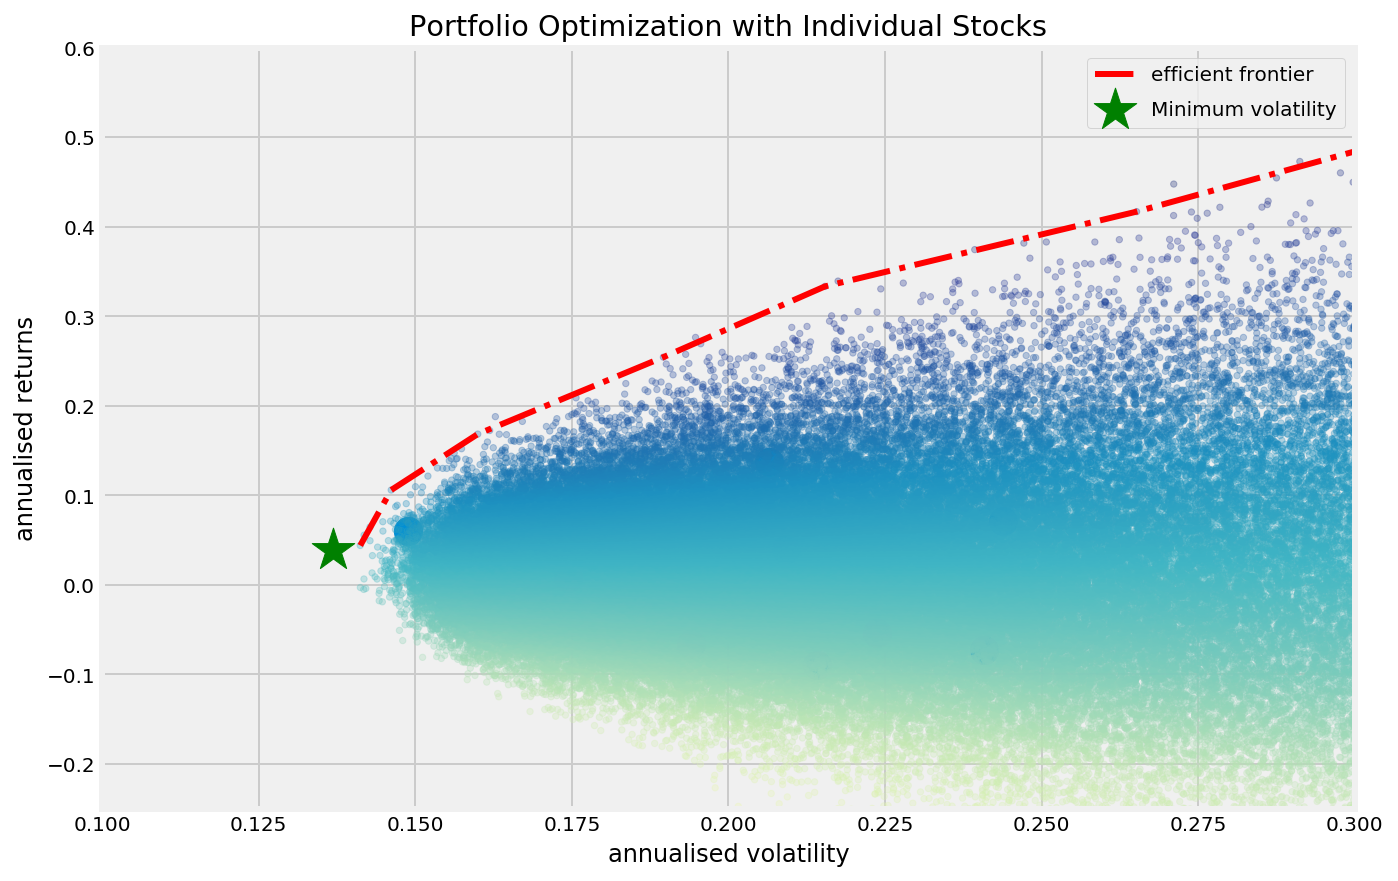

In [0]:
def display_ef(mean_returns, cov_matrix, risk_free_rate):
    #note how im using original portfolio uniform
    results, weights = original_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)#
    ef_ret = results[1,is_efficient(results, nbins)]#
    ef_std = results[0,is_efficient(results, nbins)]#

    #Optimal Only

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    
    ax.set_title('Portfolio Optimization with Individual Stocks')

    ax.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    #fig.colorbar()

    ax.plot(ef_std, ef_ret, linestyle='-.', color='red', linewidth=3,label='efficient frontier')#

    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    plt.axis([0.1, 0.3, -0.25, 0.6])
    ax.legend(labelspacing=0.8)

nbins = 20
display_ef(mean_returns, cov_matrix, risk_free_rate)